**Deep Learning 2023/24 - Final Project**
===============

Prediction of Stock Prices
---------------

## Team:
- Lukas Weigmann
- Andre Datchev
- Hannes Pohnke

-----------------------------------

Outline
1. xxx

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE


## **1. Introduction**
----------------------------------

In this project we will use LSTM Neural Networks to predict the future development of stock prices (the adjusted close in our case) based solely on historical prices of that exact stock (or index). We'll use two approaches: a straightforward, rather naive method to predict actual stock prices in the future and a more comprehensive approach categorizing stock price development into discrete groups. By analyzing the historical data, we aim to uncover insights into the predictability of stock price movements and the potential of pattern recognition in financial forecasting. For no particular reason, we chose to use data from the german DAX index and its components.

## **2. Acquiring data**

----------------------------------

We will use yfinance to load the price histories.  

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2019-02-07  24.809999  24.809999  24.500000  24.570000  21.560154    8000
2019-02-08  24.360001  24.360001  24.190001  24.339001  21.357454    5200
2019-02-11  24.240000  24.355000  24.190001  24.320000  21.340782    1100
2019-02-12  24.613001  24.764999  24.613001  24.764999  21.731266    1100
2019-02-13  24.910000  24.910000  24.680000  24.680000  21.656683    3300 
 (1259, 6) 

            Adj Close
Date                 
2019-02-07  21.560154
2019-02-08  21.357454
2019-02-11  21.340782
2019-02-12  21.731266
2019-02-13  21.656683


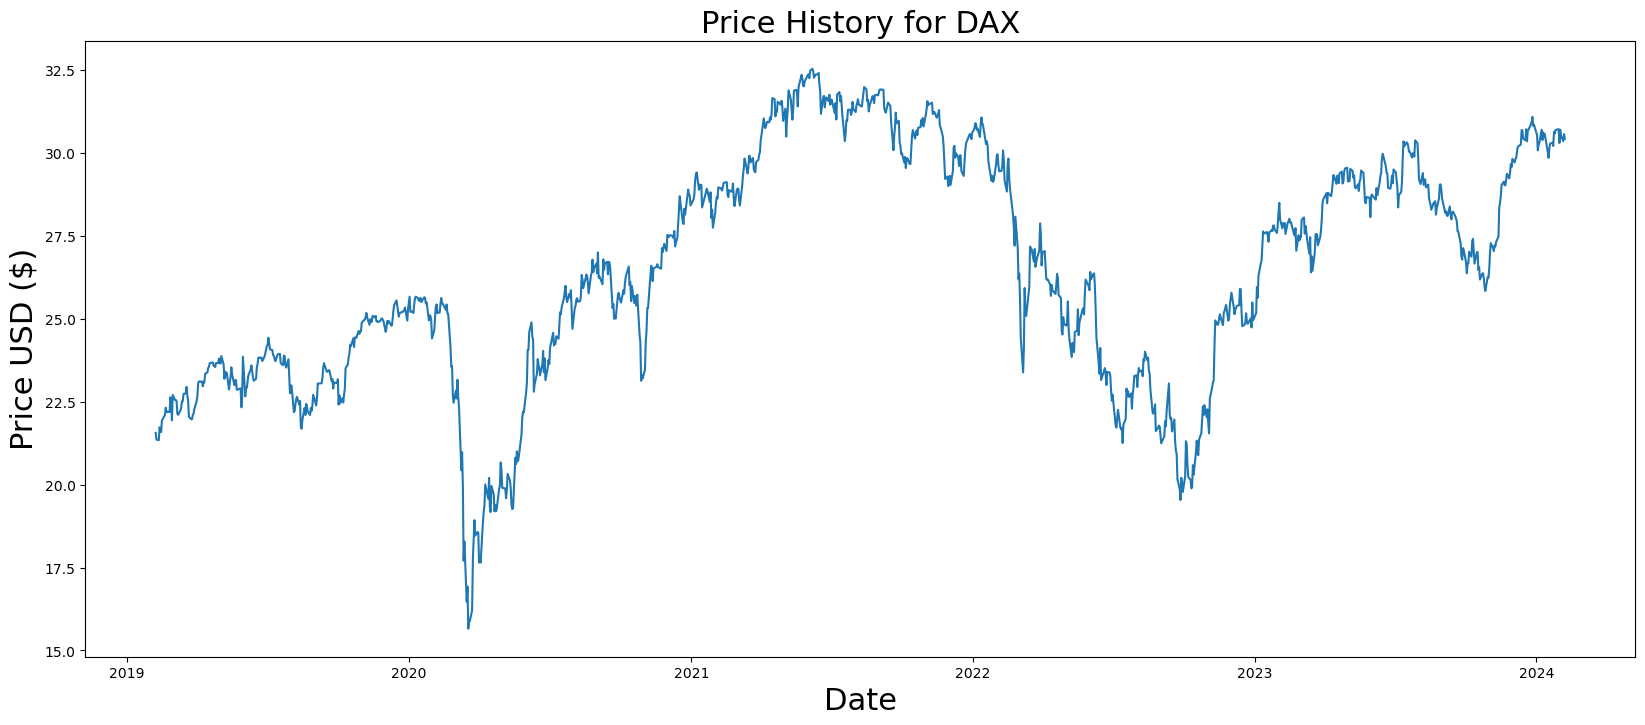

In [11]:
yf.pdr_override()
pd.set_option('display.max_rows', None)

#timeframe we want to load the data from in years
timeframe = 5

#setting end and start date 
end = datetime.now()
    #end = datetime(end .year - 1, end.month, end.day)
start = datetime(end.year - timeframe, end.month, end.day)

#how the downloaded dataframe looks
dax = pdr.get_data_yahoo("DAX", start, end)
print(dax.head(), "\n", dax.shape, "\n")

#extracting the price history
dax_history = dax.filter(["Adj Close"])
print(dax_history.head())

#visulazing
def plot_history(history, index):
    plt.figure(figsize=(20,8))
    plt.title('Price History for ' + index, fontsize=22)
    plt.plot(history)
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Price USD ($)', fontsize=22)

    plt.show()
    
plot_history(dax_history, "DAX")


In [15]:
#loading data of all DAX stock
"""
def load_histories(indices):
    stock_histories = []
    for index in indices :
        stock = pdr.get_data_yahoo(index, start, end)
        adj_close_history = stock['Adj Close']
        stock_histories.append(adj_close_history)
        
    return stock_histories

stocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', 
          '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', 
          'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', 
          'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', 
          'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', 
          'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']

dax_histories = load_histories(stocks)
"""

"\ndef load_histories(indices):\n    stock_histories = []\n    for index in indices :\n        stock = pdr.get_data_yahoo(index, start, end)\n        adj_close_history = stock['Adj Close']\n        stock_histories.append(adj_close_history)\n        \n    return stock_histories\n\nstocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', \n          '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', \n          'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', \n          'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', \n          'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', \n          'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']\n\ndax_histories = load_histories(stocks)\n"

In [16]:
#Filtering 'incomplete' histories
"""
lengths = [len(history) for history in dax_histories]

# Count the occurrences of each length
from collections import Counter
length_counts = Counter(lengths)

# Display the unique lengths and their frequencies
for length, count in length_counts.items():
    print(f"Length {length}: {count} occurrences")

filtered_histories = [history for history in dax_histories if len(history) == 763]

# Convert to NumPy array for model to use
stock_array = np.array(filtered_histories)

    """

'\nlengths = [len(history) for history in dax_histories]\n\n# Count the occurrences of each length\nfrom collections import Counter\nlength_counts = Counter(lengths)\n\n# Display the unique lengths and their frequencies\nfor length, count in length_counts.items():\n    print(f"Length {length}: {count} occurrences")\n    '

## **3. The Naive Approach**
---------------------------------

At first we will choose a naive approach, similiar to the article that was linked in the project task.   
As we will see, in this approach we just predict the price of the following day.

Link to the article: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

### 3.1 Data Preprocessing

In [12]:
#Feature Scaling
dataset = dax_history.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset[:5])

[[0.34969511]
 [0.33768871]
 [0.33670118]
 [0.3598305 ]
 [0.35541276]]


In [13]:
#lookback window for prediction:
lag = 60

#train test split:
ratio = 0.8

train_data_len = int(np.ceil( len(dataset) * ratio ))

train_data, test_data = scaled_dataset[:train_data_len, :], scaled_dataset[train_data_len - lag:]

#print(train_data[training_data_len - 10:], "\n\n", test_data[:10])
print(len(dataset), "=", len(train_data), "+", len(test_data), "+", lag)

1259 = 1008 + 311 + 60


In [14]:
# Data transformation: We will create datasamples with a corresponding label from our linear history. 
# Each sample will be <lag> consecutive values and the label y will be the price for the day after that time series.

def create_samples(sequential_data, lag=20):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)):
        x.append(sequential_data[i-lag:i, 0])
        y.append(sequential_data[i, 0])
    return np.array(x), np.array(y)

train_X, train_Y = create_samples(train_data, lag)
#print(train_X.shape)
#print(train_Y.shape)


test_X, test_Y = create_samples(test_data, lag)

#train_X

### 3.2 Our Naive Model

In [15]:
#initializing model
model = Sequential()
model.add(LSTM(8, input_shape= (lag, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
#training
model.fit(train_X, train_Y, batch_size=1, epochs=1)

948/948 [==============================] - 6s 5ms/step - loss: 0.0057


In [17]:
# making predictions
predictions = model.predict(test_X)

# scaling our predictions back to actual price values
predictions = scaler.inverse_transform(predictions)

#print(dataset[train_data_len:train_data_len + 5])
#print(predictions[:5])

8/8 [==============================] - 0s 3ms/step


<class 'pandas.core.frame.DataFrame'>


C:\Users\hajap\AppData\Local\Temp\ipykernel_2508\2179748128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


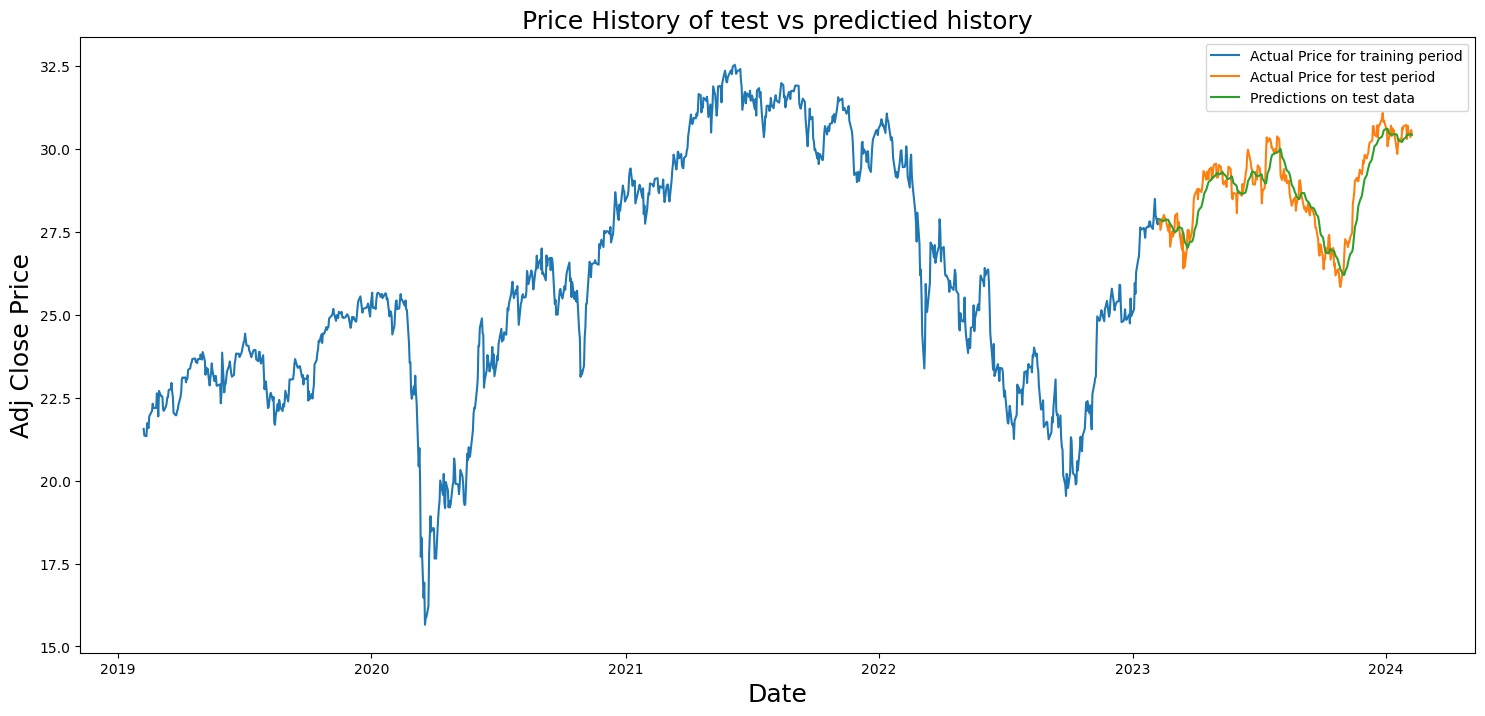

MSE: 778.0451781683031


In [18]:
mse = mean_squared_error(predictions, test_Y)
rmse = np.sqrt(mse)

#visualize Results
def plot_results(stock, train, test, preds):
    test['predictions'] = preds
    
    plt.figure(figsize=(18,8))
    plt.plot(train)
    plt.plot(test)
    plt.title(f"Price History of {stock} vs predictied history", fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price', fontsize=18)
    plt.legend(['Actual Price for training period', 'Actual Price for test period', 'Predictions on test data'])
    
    plt.show()
    

print(type(dax_history))
train_history = dax_history[:train_data_len]
test_history = dax_history[train_data_len:]
plot_results("test", train_history, test_history, predictions)

print(f"MSE: {mse}")

Our naive model is very simplistic, it consists of a single LSTM layer with 8 input neurons and got trained for just one epoch. Nevertheless, our performance looks increadibly well.  

That is because we effectivly only predict the value of the following day after an input series, but don't use our own predictions when predicting the next day after that.
What happens is, that every prediction is based on 60 (when the lag is 60) ground truth values. So everything this naive model does, is predicting a price, that is very close to the last couple values in the input series. To visualize that, we can see in the plot how the green line just mimics the orange line with a slight time delay. If we would use our own predictions as input for following predictions (i.e. predicting further into the future) the green plot would most likely look linear, predicting values close to the same last price over and over again. 

Exactly this approach has been chosen by multiple people, including the linked article and other public Kaggle notebooks.
In real life applications this model is useless though.

## **4. Adjusting the Task**
---------------------------------

Since a prediction for the next day is not really useful, we want to do a classicification in 5 categories. For this we compare the price of the current date with the price at a future point in time and categorize the increase/decrease. The idea is to get a category for a small increase, a big increase, stagnation, small decrease and big decrease. This way we want to obtain a more abstract tendency or trend, based on past data.
We consider this a more useful and robust approach since the stock price is also very dependent on daily events and in order to obtain more abstract trends the market needs a wider time frame.

(1259, 1)


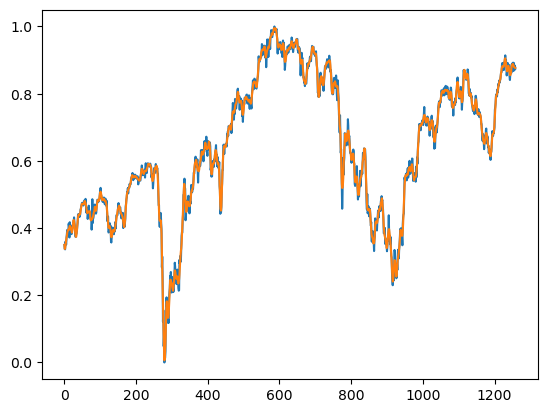

In [37]:
# Smoothing the curve with moving average
from scipy.signal import savgol_filter

plt.plot(scaled_dataset)

print(scaled_dataset.shape)

smoothed_dataset = savgol_filter(scaled_dataset[:,0], window_length=15, polyorder=5).reshape(-1,1)

plt.plot(smoothed_dataset)


In [38]:
def getTrainingAndTestData(lag=60):
    ratio = 0.8

    train_data_len = int(np.ceil( len(dataset) * ratio ))

    train_data = smoothed_dataset[:train_data_len, :]
    test_data = smoothed_dataset[train_data_len - lag:]
    
    return train_data, test_data 


In [70]:
# We will create samples that use the past <lag> days and are labelled with the category label
# according to percental change in the next <predictionPeriod>

label_map = {0: 'below -10%', 1: '-10% to -3%',2: '-3% to 3%',3: '3% to 10%',4: 'above 10%'}

def create_samples(sequential_data, category_boundaries=[-10, -3, 3, 10], shift=3, lag=60, prediction_period=7):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)-prediction_period, shift):
        x.append(sequential_data[i-lag:i, 0])
        percental_change = (sequential_data[i+prediction_period]/sequential_data[i]-1)*100
        for index, boundary in enumerate(category_boundaries):
            if percental_change <= boundary:
                y.append(index)
                break
        if percental_change > category_boundaries[3]:
            y.append(4)
    return np.array(x), np.array(y)

#WOFÜR shift?

In [80]:
train_data, test_data = getTrainingAndTestData()

train_X, train_Y = create_samples(train_data)

test_X, test_Y = create_samples(test_data)

train_X.shape, train_Y.shape

((314, 60), (314,))

We are now doing a multiclass classification, which comes with a couple new challenges.  
At first we need categorical labels.

In [91]:
train_Y_cat = to_categorical(train_Y, num_classes=5)
test_Y_cat = to_categorical(test_Y, num_classes=5)

print(train_Y)
print(train_Y_cat)

[1 2 1 1 2 3 3 2 3 3 3 3 3 1 1 2 2 1 0 0 1 1 1 2 3 3 3 4 3 3 2 1 1 1 1 4 4
 4 3 3 3 3 2 2 2 2 2 2 2 3 3 2 2 2 2 2 3 2 2 1 1 2 3 3 2 0 0 0 0 0 0 0 0 4
 4 1 4 4 2 1 4 4 3 1 1 3 4 4 4 4 4 0 1 2 2 2 3 3 3 4 4 2 1 1 3 3 3 2 2 3 2
 2 2 2 0 0 2 3 3 3 1 1 0 0 0 4 4 4 2 2 3 3 2 2 3 3 3 2 3 3 2 1 2 1 1 2 3 3
 2 2 2 2 2 3 3 2 2 2 3 3 3 3 3 2 2 2 2 2 2 3 3 2 2 2 2 2 1 1 2 2 2 2 2 1 2
 3 3 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 2 3 3 2 2 3 3 2 2 2 1 0 1 3 3 2 2 3 3
 3 2 2 2 1 0 2 3 2 2 2 1 0 0 0 0 4 4 3 2 3 1 0 1 2 2 0 1 1 1 1 3 4 3 4 3 1
 0 0 1 2 0 0 0 1 4 4 3 3 3 3 3 1 0 0 0 1 3 4 1 0 0 0 4 3 1 3 4 4 4 3 4 4 4
 4 2 3 3 2 2 2 1 1 3 3 4 4 3 2 2 3 2]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


Our data is imbalanced, as we will also see in the classification report later.  
To adress that we can weight the classes when training, to eliminate that bias.

In [92]:
# compute class weights
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_Y), y=train_Y)

# convert to dictionary
#class_weights_dict = dict(enumerate(class_weights))

Alternatively we can use Smote to artifically sample instances of less frequent classes.

In [102]:
#smote = SMOTE()

#train_X_resampled, train_Y_resampled = smote.fit_resample(train_X, train_Y_cat)


## **5. Our Model**
---------------------------------

In [113]:
#initializing model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (lag, 1)))
#model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
#model.add(Dense(16))
model.add(Dense(5, activation='softmax')) # 5 ouput neurons for the 5 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
#training
model.fit(train_X, train_Y_cat, batch_size=1, epochs=10) # without adressing imbalance performs best
#model.fit(train_X, train_Y_cat, batch_size=1, epochs=10, class_weight=class_weights_dict) # weighted class version
#model.fit(train_X_resampled, train_Y_resampled, batch_size=1, epochs=10) # smote version

Epoch 1/10


314/314 [==============================] - 6s 12ms/step - loss: 1.4971 - accuracy: 0.3280
Epoch 2/10
314/314 [==============================] - 4s 12ms/step - loss: 1.4519 - accuracy: 0.3885
Epoch 3/10
314/314 [==============================] - 4s 12ms/step - loss: 1.4431 - accuracy: 0.3949
Epoch 4/10
314/314 [==============================] - 4s 12ms/step - loss: 1.4170 - accuracy: 0.3758
Epoch 5/10
314/314 [==============================] - 4s 12ms/step - loss: 1.4042 - accuracy: 0.4236
Epoch 6/10
314/314 [==============================] - 4s 12ms/step - loss: 1.4038 - accuracy: 0.4204
Epoch 7/10
314/314 [==============================] - 5s 15ms/step - loss: 1.3967 - accuracy: 0.4076
Epoch 8/10
314/314 [==============================] - 5s 14ms/step - loss: 1.3944 - accuracy: 0.3885
Epoch 9/10
314/314 [==============================] - 5s 14ms/step - loss: 1.3876 - accuracy: 0.4013
Epoch 10/10
314/314 [==============================] - 4s 14ms/step - loss: 1.3738 - accuracy: 0.3885


In [120]:
# making predictions
predictions = model.predict(test_X)
predicted_classes = np.argmax(predictions, axis=1)

# understand the predictions
print("Last 5 true Labels:")
print(test_Y[:5])
print([label_map[key] for key in test_Y[:5]])

print("\nLast 5 Predicted Labels:")
print(predicted_classes[:5])
print([label_map[key] for key in predicted_classes[:5]])

print("\nUnique predicted classes (should be [0,1,2,3,4]):")
print(np.unique(predicted_classes))

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 13ms/step
Last 5 true Labels:
[2 1 1 2 3]
['-3% to 3%', '-10% to -3%', '-10% to -3%', '-3% to 3%', '3% to 10%']

Last 5 Predicted Labels:
[2 2 2 2 2]
['-3% to 3%', '-3% to 3%', '-3% to 3%', '-3% to 3%', '-3% to 3%']

Unique predicted classes (should be [0,1,2,3,4]):
[2]


In [116]:
# Calculate cross-entropy loss
cross_entropy = model.evaluate(test_X, test_Y_cat, verbose=0)

# Calculate classification metrics
print(f"Cross-entropy Loss: {cross_entropy[0]}")
print(f"Accuracy: {cross_entropy[1]}")

# Print classification report
print(classification_report(test_Y, predicted_classes))

# Print confusion matrix
#print(confusion_matrix(test_Y, predicted_classes))

Cross-entropy Loss: 1.3363221883773804
Accuracy: 0.45121949911117554
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.45      1.00      0.62        37
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00         5

    accuracy                           0.45        82
   macro avg       0.11      0.25      0.16        82
weighted avg       0.20      0.45      0.28        82



c:\Users\hajap\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hajap\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hajap\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**random Notes:**  
-imbalanced data -> anders samplen oder artifiically?
-bias durch marktphasen, letzten 20% könnten insgesamt besser/schlechter laufen als davor  

-außerdem: Einfluss von lag, prediction span, jahre die wir zurückschauen ???  

!PASST 81 instances für test set überhaupt?

## **x. Conclusion**
---------------------------------
fazit model, je nachdem wie gut performance 
...

While pattern recognition in stock pricing seems to be a popular way to predict future prices, it's essential to recognize its limitations.  
Stock prices are profoundly influenced by various factors such as company performance, industry dynamics, and global events, which are often unpredictable.  
Thus, relying solely on price movement patterns doesn't provide a comprehensive or reliable basis for financial forecasting.  
Instead, a balanced approach incorporating the various "real life" influences on the price, should result in a higher prediction power.